# First network tests with new code version

Goal: Get a CAM implementation.

Stick with 8 columns for now since we know that works in the PNAS version.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cbrain.imports import *
limit_mem()

In [3]:
from cbrain.utils import *

In [9]:
from cbrain.normalization import conversion_dict
from cbrain.data_generator import DataGenerator

## Create scaling dictionary for PNAS version

In [3]:
conversion_dict

{'TPHYSTND': 1004.64,
 'TPHY_NOKE': 1004.64,
 'TPHYSTND_NORAD': 1004.64,
 'PHQ': 2834700.0,
 'PHCLDLIQ': 2834700.0,
 'PHCLDICE': 2834700.0,
 'SPDT': 1004.64,
 'SPDQ': 2501000.0,
 'QRL': 1004.64,
 'QRS': 1004.64,
 'PRECT': 1728000.0,
 'TOT_PRECL': 1728.0,
 'TOT_PRECS': 1728.0,
 'PRECS': 1728000.0,
 'FLUT': 1e-05,
 'FSNT': 0.001,
 'FSDS': -0.001,
 'FSNS': -0.001,
 'FLNT': -0.001,
 'FLNS': 0.001,
 'QAP': 1574.8333333333333,
 'QCAP': 1574.8333333333333,
 'QIAP': 1574.8333333333333}

In [6]:
save_pickle('../../nn_config/scale_dicts/002_pnas_scaling.pkl', conversion_dict)

## Why do I get crazy losses during training

In [10]:
scale_dict = load_pickle('../../nn_config/scale_dicts/002_pnas_scaling.pkl')

In [11]:
in_vars = ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

In [58]:
train_gen.data_ds.close()

In [59]:
train_gen = DataGenerator(
    data_fn = '/local/S.Rasp/preprocessed_data/001_train_shuffle.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/local/S.Rasp/preprocessed_data/001_norm.nc',
    input_transform = ('mean', 'std_by_var'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [60]:
X, Y = train_gen[0]; X.shape, Y.shape

((1024, 94), (1024, 65))

In [52]:
train_gen.n_batches

13728

In [53]:
X_max, Y_max = [], []
for i in tqdm(range(train_gen.n_batches)):
    X, Y = train_gen[i]
    X_max.append(np.max(np.abs(X)))
    Y_max.append(np.max(np.abs(Y)))

In [47]:
train_gen[0][0].min()

-18.1776585710447

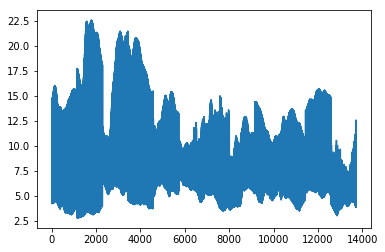

In [54]:
plt.plot(X_max);

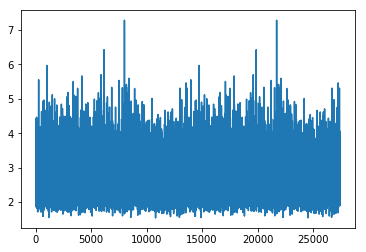

In [48]:
plt.plot(Y_max);

In [61]:
from cbrain.models import *
from cbrain.learning_rate_schedule import LRUpdate
from tensorflow.keras.callbacks import LearningRateScheduler, Callback


In [62]:
model = fc_model(
    input_shape=train_gen.n_inputs,
    output_shape=train_gen.n_outputs,
    hidden_layers=[256,256,256,256,256,256,256],
    activation='elu',
    )

In [63]:
model.compile('adam', loss='mse')

In [64]:
class TerminateOnLarge(Callback):
    """Callback that terminates training when a NaN loss is encountered.
    """

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if loss > 10_000:
                print('Batch %d: Invalid loss, terminating training' % (batch))
                self.model.stop_training = True

In [65]:
lrs = LearningRateScheduler(LRUpdate(0.001, 2, 3))

In [66]:
model.fit_generator(train_gen, epochs=1, callbacks=[lrs, TerminateOnLarge()])

Learning rate = 0.001
Epoch 1/1
13728/13728 [==============================] - 202s 15ms/step - loss: 0.0061


In [42]:
model.evaluate(*train_gen[1])

1024/1024 [==============================] - 0s 77us/step


807786.8129882812

In [46]:
X, Y = train_gen[2763]

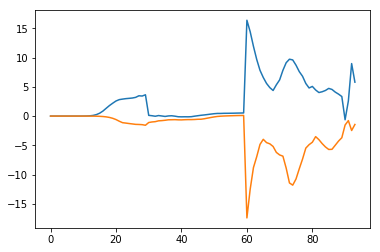

In [47]:
plt.plot(X.max(0))
plt.plot(X.min(0))

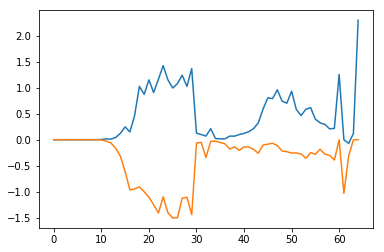

In [48]:
plt.plot(Y.max(0))
plt.plot(Y.min(0))

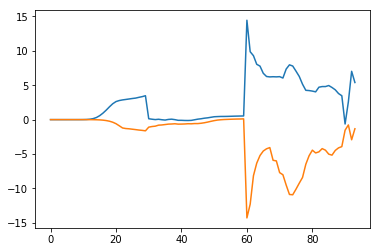

In [44]:
plt.plot(X.max(0))
plt.plot(X.min(0))

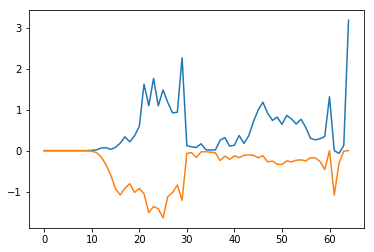

In [45]:
plt.plot(Y.max(0))
plt.plot(Y.min(0))